# DATA CHALLENGE FINAL PROJECT (ABSTRACT ANALYSIS)

# Importing libraries and exploring DF

In [5]:
import networkx as nx
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np


In [7]:
df_1 = pd.read_csv('Data/df1.csv')
df_1.columns

Index(['title', 'authors', 'year', 'venue', 'index', 'citations', 'abstract'], dtype='object')

In [8]:
df = pd.read_csv('Data/df.csv')
df.head()

,title,authors,year,venue,index,citations,abstract,cleaned_abstract,dominant_topic
0,Automated Deduction in Geometry: 5th Internati...,"Hoon Hong,Dongming Wang",2006,NaN,0,NaN,NaN,NaN,0
1,A+ Certification Core Hardware (Text & Lab Man...,Charles J. Brooks,2003,NaN,1,NaN,NaN,NaN,0
2,Performance engineering in industry: current p...,"Ahmed E. Hassan,Parminder Flora",2007,Proceedings of the 6th international workshop ...,2,NaN,This panel session discusses performance engin...,panel session discusses performance engineerin...,3
3,"Dude, You Can Do It! How to Build a Sweeet PC","Darrel Creacy,Carlito Vicencio",2005,NaN,3,NaN,Whether you're frustrated with current PC offe...,whether frustrated current pc offering inflate...,2
4,What Every Programmer Needs to Know about Secu...,"Neil Daswani,Anita Kesavan",2006,NaN,4,NaN,NaN,NaN,0


In [9]:
# Check if indices match
print("Do indices match?", df.index.equals(df_1.index))


Do indices match? True


In [10]:
# Merge df with df_1 using the index
df['citations'] = df_1['citations']



In [11]:
df['citations'] = df['citations'].apply(
    lambda x: list(map(int, x.split(';'))) if isinstance(x, str) and x.strip() else []
)


In [12]:
df['citations'].head(10)

,citations
0,[]
1,[]
2,[]
3,[]
4,[]
5,[436405]
6,[]
7,[]
8,[]
9,[]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629814 entries, 0 to 629813
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   title             629814 non-null  object
 1   authors           603898 non-null  object
 2   year              629814 non-null  int64 
 3   venue             531220 non-null  object
 4   index             629814 non-null  int64 
 5   citations         629814 non-null  object
 6   abstract          281080 non-null  object
 7   cleaned_abstract  281051 non-null  object
 8   dominant_topic    629814 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 43.2+ MB


## Create the Graph from DataFrame

In [14]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from citations
for paper_id, row in df.iterrows():
    if 'citations' in df.columns and isinstance(row['citations'], list):  # Ensure citations exist
        for cited_paper in row['citations']:
            if not pd.isna(cited_paper):
                G.add_edge(paper_id, cited_paper)

# Debug: Check the graph
print("Original Graph:")
print("Number of nodes:", len(G.nodes()))
print("Number of edges:", len(G.edges()))


Original Graph:
Number of nodes: 217335
Number of edges: 632751


##  Split Nodes into Train and Test

In [15]:
# Shuffle and split nodes
all_nodes = list(G.nodes())
random.seed(42)
random.shuffle(all_nodes)

split_index = int(0.8 * len(all_nodes))
train_nodes = set(all_nodes[:split_index])
test_nodes = set(all_nodes[split_index:])

# Debug: Check node counts
print("Train nodes count:", len(train_nodes))
print("Test nodes count:", len(test_nodes))


Train nodes count: 173868
Test nodes count: 43467


## Split Edges into Train and Test

In [16]:
# Filter edges for train and test graphs
train_edges = [(u, v) for u, v in G.edges() if u in train_nodes and v in train_nodes]
test_edges = [(u, v) for u, v in G.edges() if u in test_nodes and v in test_nodes]

# Create train and test graphs
G_train = nx.DiGraph()
G_train.add_edges_from(train_edges)

G_test = nx.DiGraph()
G_test.add_edges_from(test_edges)

# Debug: Check train and test graphs
print("Train Graph:")
print("Nodes:", len(G_train.nodes()), "Edges:", len(G_train.edges()))
print("Test Graph:")
print("Nodes:", len(G_test.nodes()), "Edges:", len(G_test.edges()))


Train Graph:
Nodes: 162097 Edges: 404969
Test Graph:
Nodes: 22670 Edges: 25400


## Generate Negative Samples

In [17]:
# Function to generate negative samples
def generate_negative_samples(G, num_samples):
    nodes = list(G.nodes())
    negative_samples = set()

    while len(negative_samples) < num_samples:
        u, v = random.choice(nodes), random.choice(nodes)
        if u != v and not G.has_edge(u, v):
            negative_samples.add((u, v))
    return list(negative_samples)

# Generate negative samples
train_negative_samples = generate_negative_samples(G_train, len(train_edges))
test_negative_samples = generate_negative_samples(G_test, len(test_edges))

# Combine positive and negative samples
train_samples_combined = train_edges + train_negative_samples
test_samples_combined = test_edges + test_negative_samples

# Assign labels
train_labels = [1] * len(train_edges) + [0] * len(train_negative_samples)
test_labels = [1] * len(test_edges) + [0] * len(test_negative_samples)


## Create DataFrames for Train and Test


In [18]:
# Create labeled DataFrames
train_df_combined = pd.DataFrame(train_samples_combined, columns=['paper_A', 'paper_B'])
train_df_combined['label'] = train_labels

test_df_combined = pd.DataFrame(test_samples_combined, columns=['paper_A', 'paper_B'])
test_df_combined['label'] = test_labels


## Add Features

In [19]:
# Example: Add shared keywords
vectorizer = CountVectorizer(stop_words='english', binary=True)
abstract_matrix = vectorizer.fit_transform(df['abstract'].fillna(''))

def compute_shared_keywords(paper_A, paper_B, matrix):
    set_A = set(matrix[paper_A].nonzero()[1])
    set_B = set(matrix[paper_B].nonzero()[1])
    return len(set_A.intersection(set_B))

train_df_combined['shared_keywords'] = [
    compute_shared_keywords(row['paper_A'], row['paper_B'], abstract_matrix)
    for _, row in train_df_combined.iterrows()
]

test_df_combined['shared_keywords'] = [
    compute_shared_keywords(row['paper_A'], row['paper_B'], abstract_matrix)
    for _, row in test_df_combined.iterrows()
]




### Map Dominant Topics

The primary topic assigned to paper_A and paper_B based on topic modeling (e.g., LDA).

In [20]:
# Map dominant topics from df to train_df_combined and test_df_combined
train_df_combined['dominant_topic_A'] = train_df_combined['paper_A'].map(df['dominant_topic'])
train_df_combined['dominant_topic_B'] = train_df_combined['paper_B'].map(df['dominant_topic'])

test_df_combined['dominant_topic_A'] = test_df_combined['paper_A'].map(df['dominant_topic'])
test_df_combined['dominant_topic_B'] = test_df_combined['paper_B'].map(df['dominant_topic'])

# Verify the updated DataFrames
print("Train DataFrame with Dominant Topics:")
print(train_df_combined[['paper_A', 'paper_B', 'dominant_topic_A', 'dominant_topic_B']].head())

print("\nTest DataFrame with Dominant Topics:")
print(test_df_combined[['paper_A', 'paper_B', 'dominant_topic_A', 'dominant_topic_B']].head())


Train DataFrame with Dominant Topics:
   paper_A  paper_B  dominant_topic_A  dominant_topic_B
0        5   436405                 1                 1
1   436405    94584                 1                 0
2   436405   282290                 1                 0
3   436405   564235                 1                 0
4   436405   594837                 1                 0

Test DataFrame with Dominant Topics:
   paper_A  paper_B  dominant_topic_A  dominant_topic_B
0       17   294124                 0                 0
1   378077    74805                 0                 0
2      225   120985                 0                 0
3   120985   280345                 0                 0
4   120985   441542                 0                 0


### Temporal influence
Helps identify temporal relationships (e.g., newer papers citing older ones).

In [23]:
# Map publication years for train_df_combined
train_df_combined['year_A'] = train_df_combined['paper_A'].map(df['year'])
train_df_combined['year_B'] = train_df_combined['paper_B'].map(df['year'])

# Map publication years for test_df_combined
test_df_combined['year_A'] = test_df_combined['paper_A'].map(df['year'])
test_df_combined['year_B'] = test_df_combined['paper_B'].map(df['year'])

# Add binary feature for temporal influence
train_df_combined['temporal_influence'] = (train_df_combined['year_A'] < train_df_combined['year_B']).astype(int)
test_df_combined['temporal_influence'] = (test_df_combined['year_A'] < test_df_combined['year_B']).astype(int)


### Shared venue
Binary feature indicating whether paper_A and paper_B were published in the same venue.

In [24]:
# Map venues for papers
train_df_combined['venue_A'] = train_df_combined['paper_A'].map(df['venue'])
train_df_combined['venue_B'] = train_df_combined['paper_B'].map(df['venue'])

test_df_combined['venue_A'] = test_df_combined['paper_A'].map(df['venue'])
test_df_combined['venue_B'] = test_df_combined['paper_B'].map(df['venue'])

# Add binary feature for shared venue
train_df_combined['shared_venue'] = (train_df_combined['venue_A'] == train_df_combined['venue_B']).astype(int)
test_df_combined['shared_venue'] = (test_df_combined['venue_A'] == test_df_combined['venue_B']).astype(int)


### The degree centrality

The degree centrality of paper_A and paper_B in the graph, representing how connected each paper is.

In [27]:
# Compute degree centrality for G_train and G_test
degree_centrality_train = nx.degree_centrality(G_train)
degree_centrality_test = nx.degree_centrality(G_test)

# Map degree centrality for train_df_combined
train_df_combined['degree_centrality_A'] = train_df_combined['paper_A'].map(degree_centrality_train)
train_df_combined['degree_centrality_B'] = train_df_combined['paper_B'].map(degree_centrality_train)

# Map degree centrality for test_df_combined
test_df_combined['degree_centrality_A'] = test_df_combined['paper_A'].map(degree_centrality_test)
test_df_combined['degree_centrality_B'] = test_df_combined['paper_B'].map(degree_centrality_test)

# Compute product of degree centralities
train_df_combined['degree_centrality_product'] = train_df_combined['degree_centrality_A'] * train_df_combined['degree_centrality_B']
test_df_combined['degree_centrality_product'] = test_df_combined['degree_centrality_A'] * test_df_combined['degree_centrality_B']


### Reciprocal_citation
Binary feature indicating whether paper_A cites paper_B and vice versa

In [28]:
# Function to compute reciprocal citation
def compute_reciprocal_citation(G, df_pairs):
    return [
        int(G.has_edge(row['paper_A'], row['paper_B']) and G.has_edge(row['paper_B'], row['paper_A']))
        for _, row in df_pairs.iterrows()
    ]
# Compute reciprocal citation for train graph
train_df_combined['reciprocal_citation'] = compute_reciprocal_citation(G_train, train_df_combined)

# Compute reciprocal citation for test graph
test_df_combined['reciprocal_citation'] = compute_reciprocal_citation(G_test, test_df_combined)


### Author collaboration_history

Binary feature indicating whether any authors of paper_A have collaborated with authors of paper_B.

In [29]:
# Preprocess authors column
df['authors'] = df['authors'].fillna('').apply(lambda x: x.split(',') if x else [])

# Debug: Check the processed authors column
print("Sample processed authors column:")
print(df['authors'].head())

# Map authors for train_df_combined
train_df_combined['authors_A'] = train_df_combined['paper_A'].map(df['authors'])
train_df_combined['authors_B'] = train_df_combined['paper_B'].map(df['authors'])

# Map authors for test_df_combined
test_df_combined['authors_A'] = test_df_combined['paper_A'].map(df['authors'])
test_df_combined['authors_B'] = test_df_combined['paper_B'].map(df['authors'])

# Build the collaboration graph
collaboration_graph = nx.Graph()

for authors in df['authors']:
    if authors:  # Skip empty author lists
        collaboration_graph.add_edges_from([(a1, a2) for a1 in authors for a2 in authors if a1 != a2])

# Debug: Check the collaboration graph
print("Collaboration Graph:")
print("Number of nodes:", collaboration_graph.number_of_nodes())
print("Number of edges:", collaboration_graph.number_of_edges())




Sample processed authors column:
0            [Hoon Hong, Dongming Wang]
1                   [Charles J. Brooks]
2    [Ahmed E. Hassan, Parminder Flora]
3     [Darrel Creacy, Carlito Vicencio]
4         [Neil Daswani, Anita Kesavan]
Name: authors, dtype: object
Collaboration Graph:
Number of nodes: 505016
Number of edges: 1137011


In [30]:
# Function to check collaboration history
def check_collaboration(authors_A, authors_B):
    if not authors_A or not authors_B:  # Handle empty author lists
        return 0
    for author_A in authors_A:
        for author_B in authors_B:
            if collaboration_graph.has_edge(author_A, author_B):
                return 1
    return 0

# Compute collaboration history for train_df_combined
train_df_combined['collaboration_history'] = [
    check_collaboration(authors_A, authors_B)
    for authors_A, authors_B in zip(train_df_combined['authors_A'], train_df_combined['authors_B'])
]

# Compute collaboration history for test_df_combined
test_df_combined['collaboration_history'] = [
    check_collaboration(authors_A, authors_B)
    for authors_A, authors_B in zip(test_df_combined['authors_A'], test_df_combined['authors_B'])
]


In [31]:
# Shuffle the training and testing data
train_df_combined = train_df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
test_df_combined = test_df_combined.sample(frac=1, random_state=42).reset_index(drop=True)


In [32]:
train_df_combined.columns

Index(['paper_A', 'paper_B', 'label', 'shared_keywords', 'dominant_topic_A',
       'dominant_topic_B', 'year_A', 'year_B', 'venue_A', 'venue_B',
       'shared_venue', 'degree_centrality_A', 'degree_centrality_B',
       'degree_centrality_product', 'reciprocal_citation', 'authors_A',
       'authors_B', 'collaboration_history'],
      dtype='object')

In [ ]:
# Define features
features = [
    'shared_keywords', 'graph_distance', 'temporal_influence',
    'shared_venue', 'degree_centrality_product', 'pagerank_sum',
    'reciprocal_citation', 'collaboration_history', 'temporal_influence'
]

X_train = train_df_combined[features]
y_train = train_df_combined['label']
X_test = test_df_combined[features]
y_test = test_df_combined['label']

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))


In [33]:
# Define features and target
features = [
    'shared_keywords', 'dominant_topic_A', 'dominant_topic_B',
    'year_A', 'year_B', 'shared_venue', 'degree_centrality_A',
    'degree_centrality_B', 'degree_centrality_product',
    'reciprocal_citation', 'collaboration_history', 'temporal_influence'
]

X_train = train_df_combined[features]
y_train = train_df_combined['label']

X_test = test_df_combined[features]
y_test = test_df_combined['label']


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [35]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute AUC-ROC
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.55      0.70     25400
           1       0.69      0.99      0.81     25400

    accuracy                           0.77     50800
   macro avg       0.83      0.77      0.76     50800
weighted avg       0.83      0.77      0.76     50800

AUC-ROC Score: 0.9131784402318806


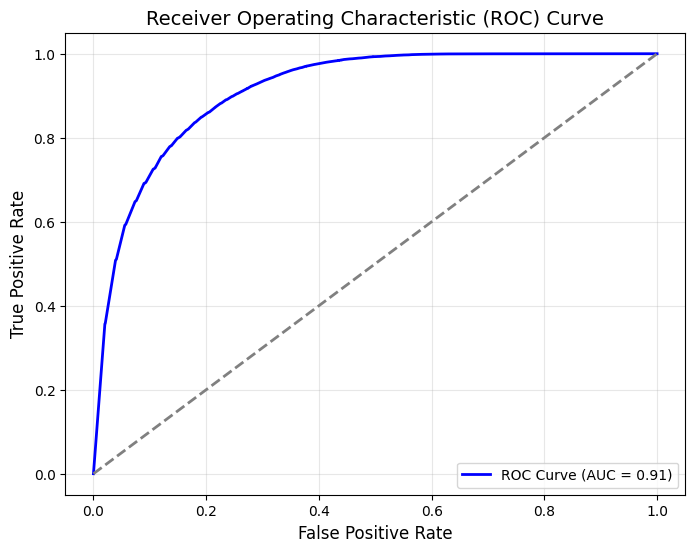

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Compute AUC score
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.43      0.60     25400
           1       0.64      1.00      0.78     25400

    accuracy                           0.71     50800
   macro avg       0.81      0.71      0.69     50800
weighted avg       0.81      0.71      0.69     50800

AUC-ROC Score: 0.9235994908239815


In [39]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.43      0.60     25400
           1       0.64      1.00      0.78     25400

    accuracy                           0.71     50800
   macro avg       0.81      0.71      0.69     50800
weighted avg       0.81      0.71      0.69     50800

AUC-ROC Score: 0.9235994908239815


In [40]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Linear Regression (Ridge)': RidgeClassifier()
}

# Store AUC scores and ROC data
auc_scores = {}
roc_data = {}

# Train each model and collect results
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities or decision function
    if model_name == 'Linear Regression (Ridge)':
        y_proba = model.decision_function(X_test)
    else:
        y_proba = model.predict_proba(X_test)[:, 1]

    # Compute AUC and ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Save results
    auc_scores[model_name] = roc_auc
    roc_data[model_name] = (fpr, tpr)

    # Print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, (y_proba > 0.5).astype(int)))
    print("\n")

# Create a DataFrame for performance comparison
performance_df = pd.DataFrame({
    'Model': list(auc_scores.keys()),
    'AUC-ROC': list(auc_scores.values())
})

# Display the performance table
print("Performance Metrics:")
print(performance_df)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72     25400
           1       0.73      0.67      0.70     25400

    accuracy                           0.71     50800
   macro avg       0.71      0.71      0.71     50800
weighted avg       0.71      0.71      0.71     50800



Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.55      0.70     25400
           1       0.69      0.99      0.81     25400

    accuracy                           0.77     50800
   macro avg       0.83      0.77      0.76     50800
weighted avg       0.83      0.77      0.76     50800



Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.99      0.43      0.60     25400
           1       0.64      1.00      0.78     25400

    accuracy                           0.71  

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:18:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.56      0.72     25400
           1       0.69      0.99      0.82     25400

    accuracy                           0.78     50800
   macro avg       0.84      0.78      0.77     50800
weighted avg       0.84      0.78      0.77     50800



Classification Report for Linear Regression (Ridge):
              precision    recall  f1-score   support

           0       0.57      0.97      0.72     25400
           1       0.89      0.27      0.42     25400

    accuracy                           0.62     50800
   macro avg       0.73      0.62      0.57     50800
weighted avg       0.73      0.62      0.57     50800



Performance Metrics:
                       Model   AUC-ROC
0        Logistic Regression  0.815406
1              Random Forest  0.913178
2          Gradient Boosting  0.923599
3                    XGBoost  0.940134
4  Linear Regression (Ridge)  0.820404

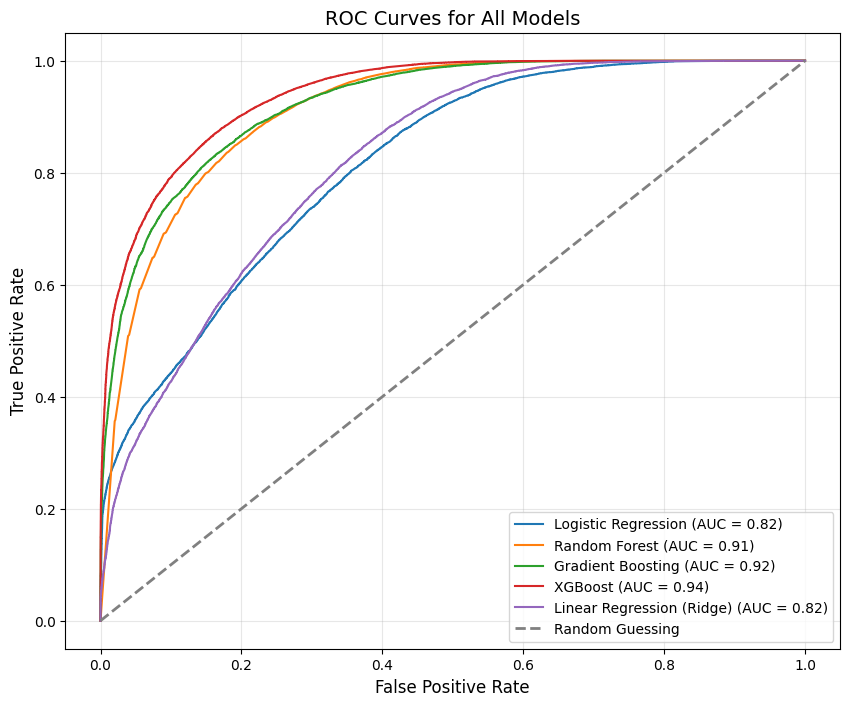

In [41]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_scores[model_name]:.2f})")

# Add baseline and labels
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label="Random Guessing")
plt.title("ROC Curves for All Models", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
